## Read Features from CSV File

In [268]:
import pandas as pd
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score


# Replace 'path_to_file.csv' with the actual path to your CSV file
file_path = 'ecg_results.csv'

# Read the CSV file into a DataFrame
ecg_feature_data = pd.read_csv(
    file_path,
    sep=',',
    header=0,
    usecols=['Participant', 'Type', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN'],
)

experiment_data = pd.read_csv(
    "all_apps_wide-2024-03-13.csv",
    sep=',',
    header=0,
    usecols=['participant.code', 'stockmarket.40.player.final_payout', 'stockmarket.40.player.final_score'],
)

# Merge the DataFrames
merged_df = pd.merge(ecg_feature_data, experiment_data, left_on='Participant', right_on='participant.code')

ecg_features = [col for col in ecg_feature_data.columns if col != 'Participant' and col != 'Type']
target = [col for col in experiment_data.columns if col != 'participant.code']

X = merged_df[ecg_features]
Y = merged_df[target]


# print(merged_df.head(20)) # Display th first few rows of the DataFrame

## Define the models

In [269]:
# Dictionary of models to train
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# For multi-output regression, we need to wrap single-output models
multi_output_models = {name: MultiOutputRegressor(model) for name, model in models.items()}


## Train and Evaluate the Models

In [270]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE', 'R²', 'Score'])

Y_preds = {}

# Function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, Y_test):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    
    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    score = model.score(X_test, Y_test)
    mae = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
    r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')
    
    mse = [round(val, 3) for val in mse]
    mae = [round(val, 3) for val in mae]
    r2 = [round(val, 3) for val in r2]
    score = round(score, 3)
    
    global results_df
    results_df = results_df._append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'Score': score
    }, ignore_index=True)
    
    return Y_pred

# Train and evaluate each model
for name, model in multi_output_models.items():
    Y_preds[name] = evaluate_model(name, model, X_train, Y_train, X_test, Y_test)
    
print(results_df)

                      Model                MSE              MAE              R²  Score
0         Linear Regression  [3.001, 1026.946]  [1.423, 26.318]  [0.788, 0.788]  0.788
1             Random Forest   [0.815, 271.686]   [0.488, 8.942]  [0.942, 0.944]  0.943
2  Support Vector Regressor  [11.99, 4830.606]  [2.596, 51.627]  [0.153, 0.004]  0.079


## Visualize the Results

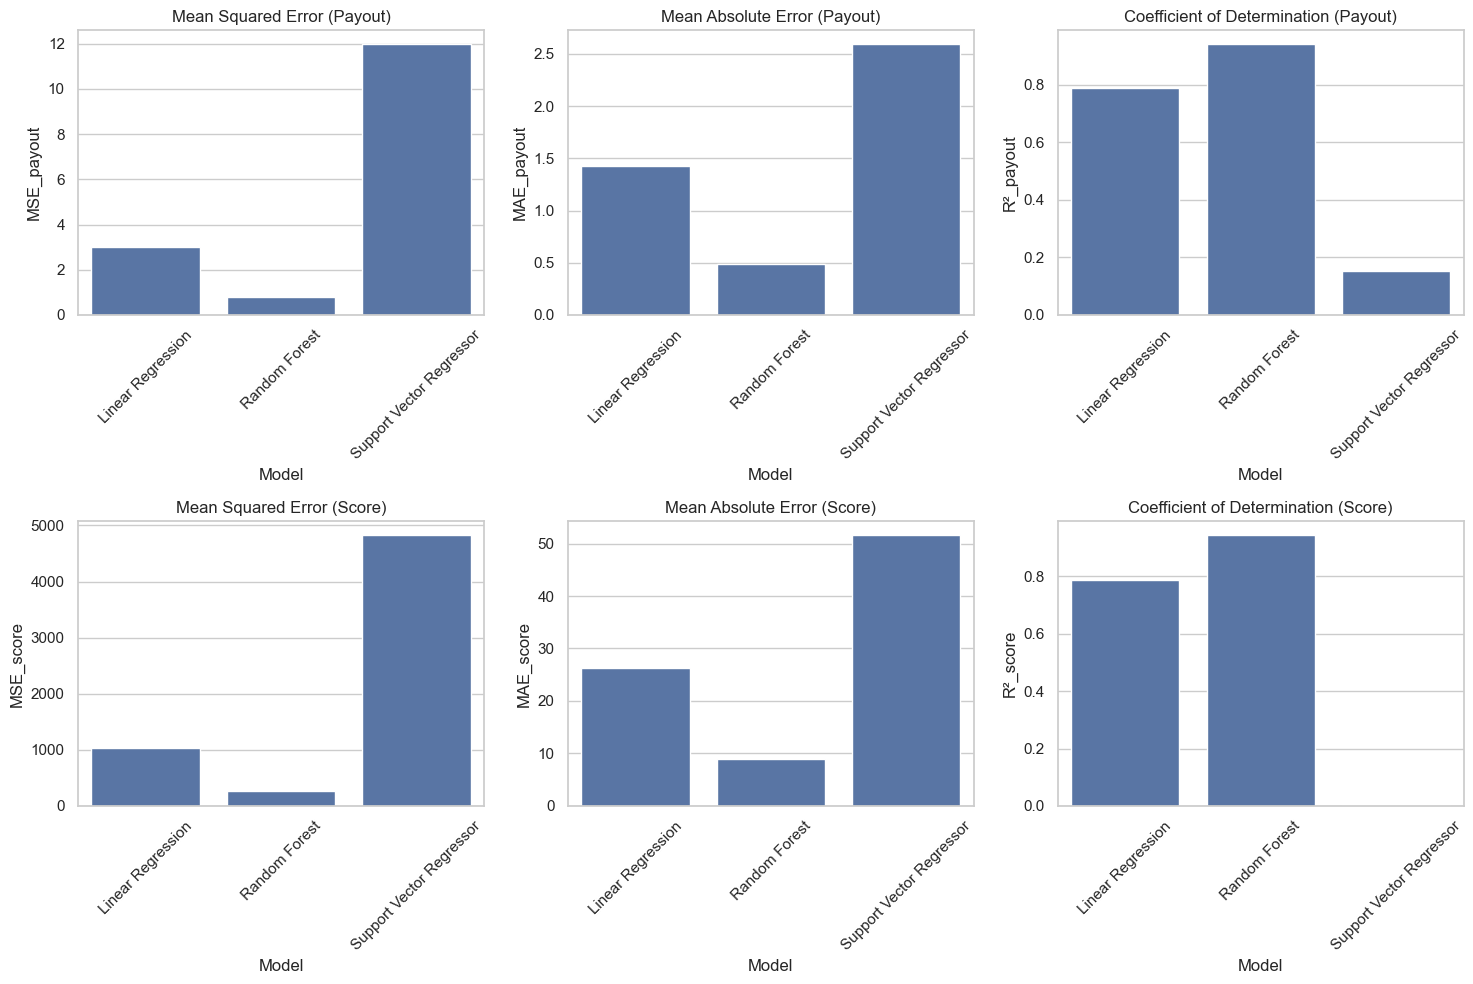

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split the 'MSE', 'MAE' and 'R² column into two separate columns
results_df[['MSE_payout', 'MSE_score']] = pd.DataFrame(results_df['MSE'].to_list(), index=results_df.index)
results_df[['MAE_payout', 'MAE_score']] = pd.DataFrame(results_df['MAE'].to_list(), index=results_df.index)
results_df[['R²_payout', 'R²_score']] = pd.DataFrame(results_df['R²'].to_list(), index=results_df.index)

# Convert the new columns to numeric data type
results_df['MSE_payout'] = pd.to_numeric(results_df['MSE_payout'])
results_df['MSE_score'] = pd.to_numeric(results_df['MSE_score'])
results_df['MAE_payout'] = pd.to_numeric(results_df['MAE_payout'])
results_df['MAE_score'] = pd.to_numeric(results_df['MAE_score'])
results_df['R²_payout'] = pd.to_numeric(results_df['R²_payout'])
results_df['R²_score'] = pd.to_numeric(results_df['R²_score'])

# Set the style of the plots
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Create a bar plot for MSE of payout
sns.barplot(x='Model', y='MSE_payout', data=results_df, ax=axes[0, 0])
axes[0, 0].set_title('Mean Squared Error (Payout)')

# Create a bar plot for MSE of score
sns.barplot(x='Model', y='MSE_score', data=results_df, ax=axes[1, 0])
axes[1, 0].set_title('Mean Squared Error (Score)')

# Create a bar plot for MAE of payout
sns.barplot(x='Model', y='MAE_payout', data=results_df, ax=axes[0, 1])
axes[0, 1].set_title('Mean Absolute Error (Payout)')

# Create a bar plot for MAE of score
sns.barplot(x='Model', y='MAE_score', data=results_df, ax=axes[1, 1])
axes[1, 1].set_title('Mean Absolute Error (Score)')

# Create a bar plot for R² of payout
sns.barplot(x='Model', y='R²_payout', data=results_df, ax=axes[0, 2])
axes[0, 2].set_title('Coefficient of Determination (Payout)')

# Create a bar plot for R² of score
sns.barplot(x='Model', y='R²_score', data=results_df, ax=axes[1, 2])
axes[1, 2].set_title('Coefficient of Determination (Score)')

# Rotate x-axis labels for better visibility
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)

# Display the plots
plt.tight_layout()
plt.show()

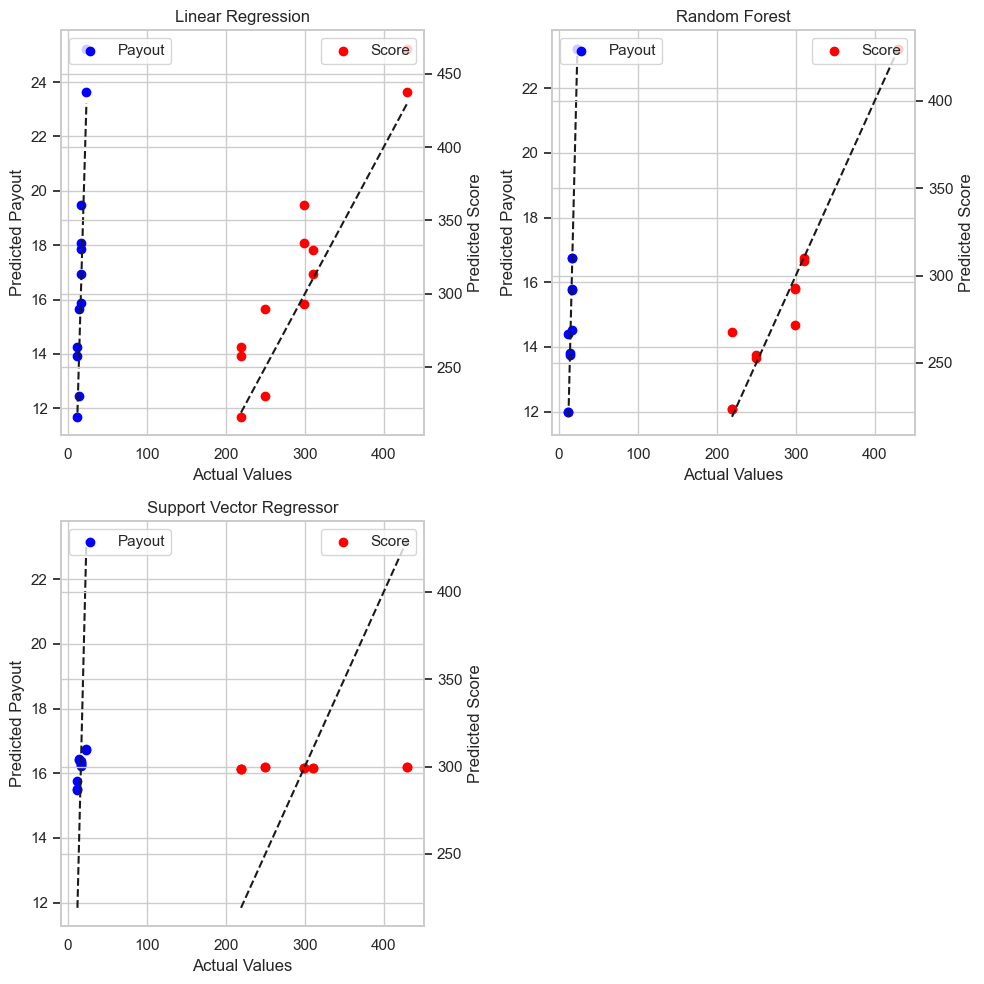

In [272]:
# Determine the number of models
num_models = len(Y_preds)

# Calculate the number of rows and columns for the subplots
num_rows = num_models // 2 + num_models % 2
num_cols = 2 if num_models > 1 else 1

# Create a new figure for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

# Flatten the axes array in case it's multidimensional
axes = axes.flatten()

# Iterate over the Y_preds dictionary and the axes
for (model_name, Y_pred), ax in zip(Y_preds.items(), axes):
    # Create a scatter plot on the current axes for the payout target
    ax.scatter(Y_test.iloc[:, 0], Y_pred[:, 0], color='blue', label='Payout')

    # Create a secondary y-axis
    ax2 = ax.twinx()

    # Create a scatter plot on the secondary y-axis for the score target
    ax2.scatter(Y_test.iloc[:, 1], Y_pred[:, 1], color='red', label='Score')

    # Set the labels and title
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Payout')
    ax2.set_ylabel('Predicted Score')
    ax.set_title(f'{model_name}')

    # Add legends
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Add bisecting line for payout and score targets
    ax.plot([Y_test.iloc[:, 0].min(), Y_test.iloc[:, 0].max()], [Y_test.iloc[:, 0].min(), Y_test.iloc[:, 0].max()], 'k--')
    ax2.plot([Y_test.iloc[:, 1].min(), Y_test.iloc[:, 1].max()], [Y_test.iloc[:, 1].min(), Y_test.iloc[:, 1].max()], 'k--')

# Remove any unused subplots
for ax in axes[num_models:]:
    fig.delaxes(ax)

# Display the plots
plt.tight_layout()
plt.show()